# Configuration

In [1]:
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import seaborn as sns

import utils.visualization as v

# Pretty display for notebooks
%matplotlib inline

# Autoreload
%load_ext autoreload
%autoreload 2

# No max columns when displaying data frames
pd.options.display.max_columns = None
pd.options.display.float_format = '{:.4f}'.format

# SNS config
sns.set()
sns.set_style("white")
sns.set_context("notebook", font_scale=1.3)

# Load data

## Create reduced dataset

In [2]:
data_raw = pd.read_csv('../data/train_V2.csv')

# Filter the solo fpp matches
data = data_raw[data_raw.matchType == 'solo-fpp']

# Drop unnecessary variables
unnecessary_cols = ['Id', 'groupId', 'matchId', 'matchType', 'killPoints', 'rankPoints',
                    'teamKills', 'revives', 'assists', 'numGroups', 'maxPlace', 'DBNOs']
data = data.drop(unnecessary_cols, axis=1)

# There is a row with winPlacePerc set to NaN
data = data.dropna()

data.to_csv('../data/pubg_dataset.csv', index=False)

## Load data

In [3]:
# Load data
data_raw = pd.read_csv('../data/pubg_dataset.csv')

---

# Data Exploration

## Statistics

In [4]:
data_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
boosts,536761.0000,1.0590,1.7916,0.0000,0.0000,0.0000,2.0000,28.0000
damageDealt,536761.0000,118.9188,158.3458,0.0000,0.0000,75.7900,171.0000,2305.0000
headshotKills,536761.0000,0.2516,0.6335,0.0000,0.0000,0.0000,0.0000,16.0000
heals,536761.0000,1.0097,2.3835,0.0000,0.0000,0.0000,1.0000,63.0000
killPlace,536761.0000,48.0256,27.5799,1.0000,24.0000,48.0000,72.0000,100.0000
kills,536761.0000,0.9347,1.4960,0.0000,0.0000,0.0000,1.0000,23.0000
killStreaks,536761.0000,0.4825,0.5564,0.0000,0.0000,0.0000,1.0000,5.0000
longestKill,536761.0000,21.7011,45.7170,0.0000,0.0000,0.0000,22.0600,940.1000
matchDuration,536761.0000,1577.0820,249.3723,1044.0000,1377.0000,1439.0000,1854.0000,2199.0000
rideDistance,536761.0000,403.2097,1270.6461,0.0000,0.0000,0.0000,0.0000,40710.0000


## Distribution plots

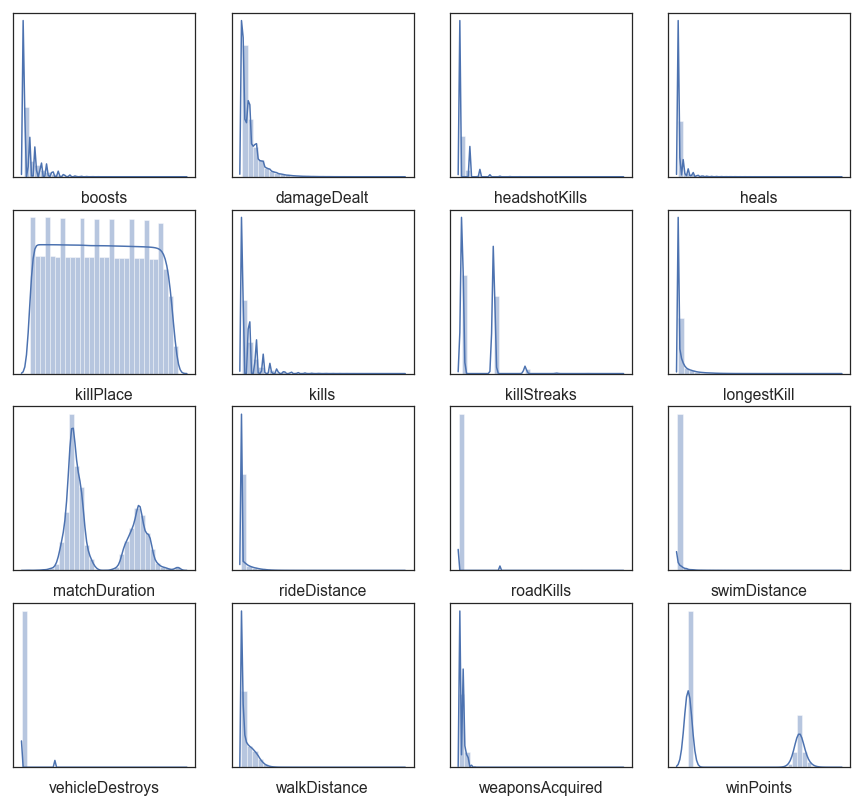

In [5]:
feature_names = data_raw.columns[:-1]

v.distplot_all_cols(data_raw, columns=feature_names, bins=30)

## Box plots

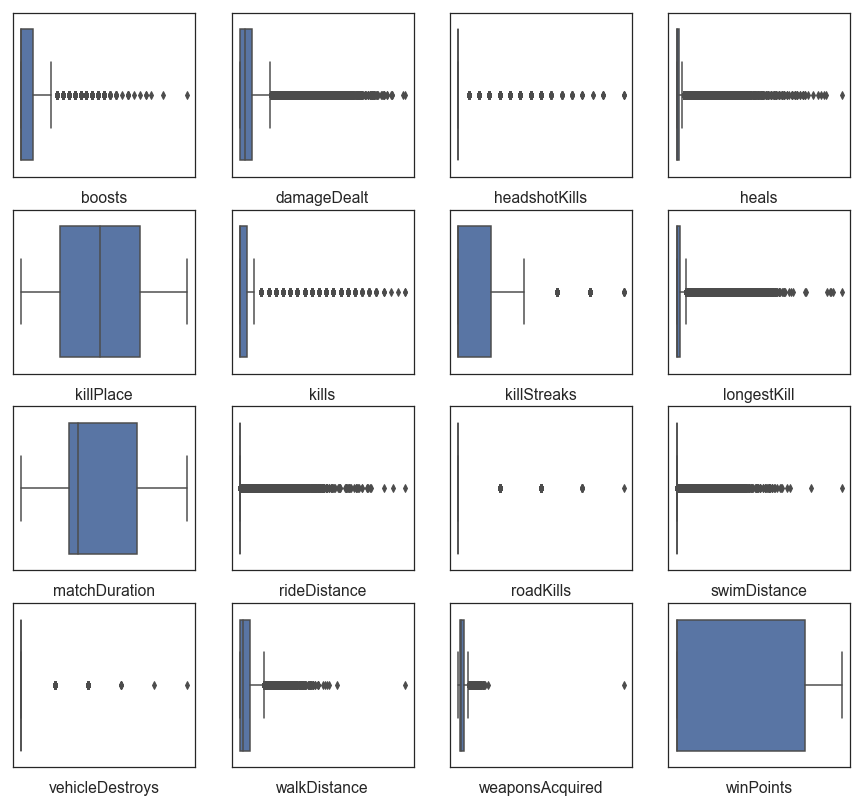

In [6]:
v.boxplot_all_cols(data_raw, columns=feature_names)

# Benchmark

In [7]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split

import config
from utils.model import train_predict


X = data_raw.drop('winPlacePerc', axis=1)
y = data_raw['winPlacePerc']

regressor_benchmark = AdaBoostRegressor(random_state=config.RANDOM_STATE)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=config.RANDOM_STATE
)

results_benchmark = train_predict(regressor_benchmark, X_train, y_train, X_test, y_test)

print(
    f'Train time:      {results_benchmark["train_time"]:7.4f}\n'
    f'Prediction time: {results_benchmark["pred_time"]:7.4f}\n'
    f'MAE train:       {results_benchmark["mae_train"]:7.4f}\n'
    f'MAE test:        {results_benchmark["mae_test"]:7.4f}'
)

Train time:      26.7142
Prediction time:  1.1087
MAE train:        0.0711
MAE test:         0.0712


# Preprocessing

In [8]:
from utils.preprocessing import *

# Remove outliers
data_no_outliers = remove_outliers(data)

# Feature scaling
data_scaled = scale_skewed_features(data_no_outliers)

# Normalize features
data_normalized = min_max_scale(data_scaled)

/Users/paco/.virtualenvs/delete_me/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


/Users/paco/.virtualenvs/delete_me/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


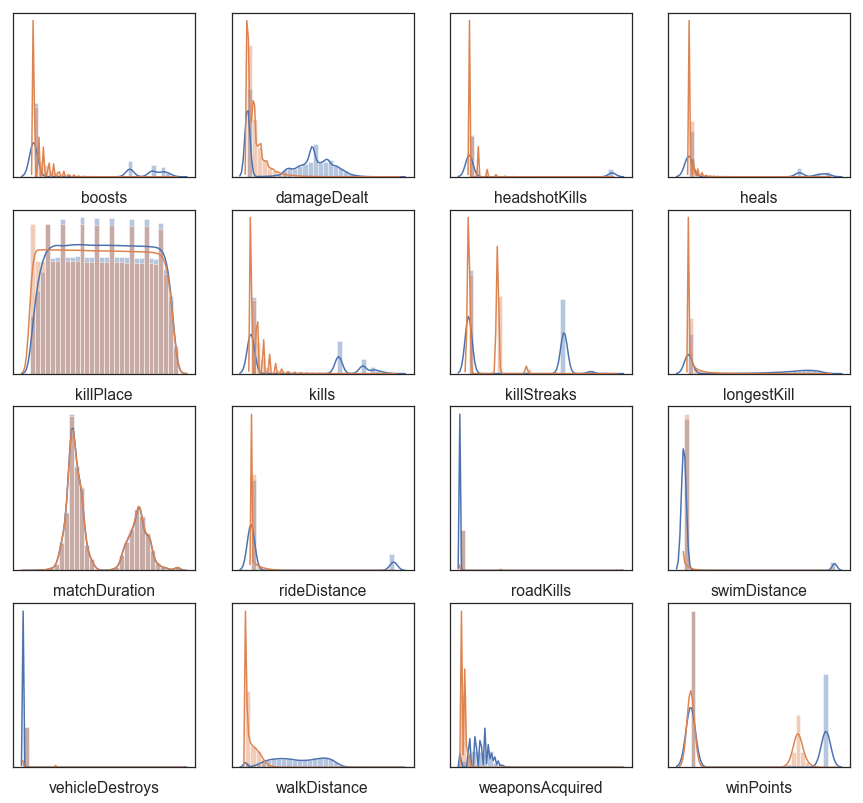

In [9]:
data_raw_normalized = min_max_scale(data_raw)
v.distplot_all_cols(data_normalized, data_raw_normalized, columns=feature_names, bins=30)

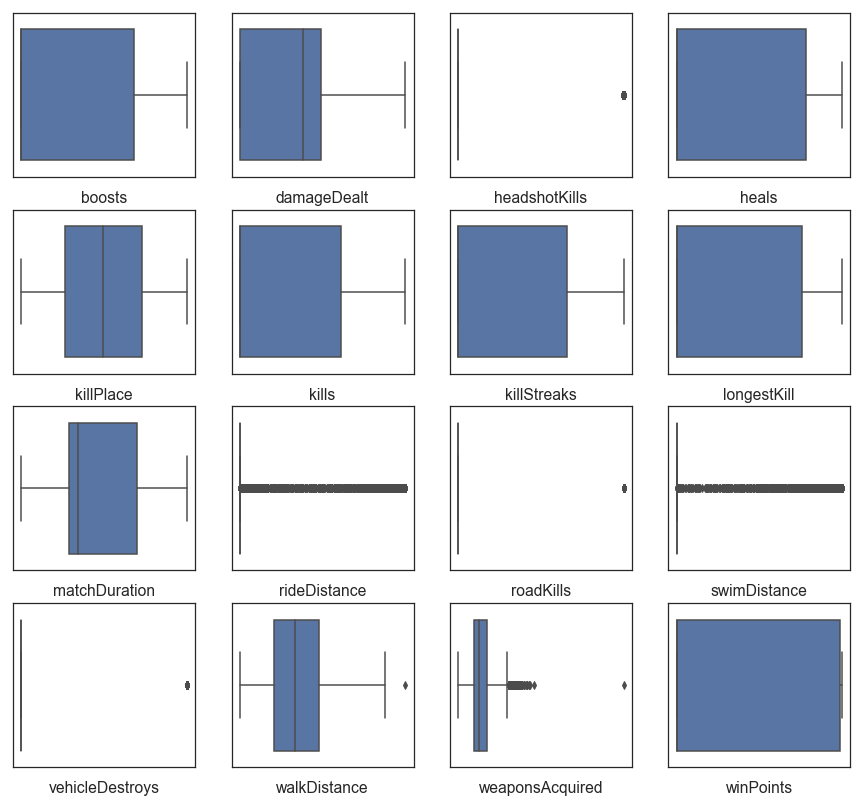

In [10]:
v.boxplot_all_cols(data_normalized, columns=feature_names)

---

# Basic Random Forest regressor

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import config
from utils.model import train_predict


X = data_normalized.drop('winPlacePerc', axis=1)
y = data_normalized['winPlacePerc']

regressor_rf = RandomForestRegressor(random_state=config.RANDOM_STATE)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=config.RANDOM_STATE
)

results_rf = train_predict(regressor_rf, X_train, y_train, X_test, y_test)

print(
    f'Train time:      {results_rf["train_time"]:7.4f}\n'
    f'Prediction time: {results_rf["pred_time"]:7.4f}\n'
    f'MAE train:       {results_rf["mae_train"]:7.4f}\n'
    f'MAE test:        {results_rf["mae_test"]:7.4f}'
)

/Users/paco/.virtualenvs/delete_me/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train time:      32.2706
Prediction time:  4.3219
MAE train:        0.0191
MAE test:         0.0484


# Parameter tuning

I executed this outside of the notebook, and it takes to long to execute again in here, so I'll just note the best parameters it found:

* `n_estimators = 200`
* `max_features = 'auto'`
* `min_samples_leaf = 8`
* `min_samples_split = 2`

In [ ]:
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV

# Separate features
X = data_normalized.drop('winPlacePerc', axis=1)
y = data_normalized['winPlacePerc']

# Init grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [2, 4, 8],
    'min_samples_split': [2, 4, 8],
}

regressor = RandomForestRegressor(random_state=config.RANDOM_STATE)
scorer = make_scorer(mean_absolute_error)
grid = GridSearchCV(
    estimator=regressor,
    param_grid=param_grid,
    scoring=scorer,
    cv=3, verbose=50, n_jobs=-1
)
grid = grid.fit(X, y)

print(f'Best parameters are {grid.best_params_}')

## Regressor with tuned parameters

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import config
from utils.model import train_predict


X = data_normalized.drop('winPlacePerc', axis=1)
y = data_normalized['winPlacePerc']

regressor_rf_tuned = RandomForestRegressor(
    random_state=config.RANDOM_STATE,
    n_estimators=200, max_features='auto',
    min_samples_leaf=8, min_samples_split=2
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=config.RANDOM_STATE
)

results_rf_tuned = train_predict(regressor_rf_tuned, X_train, y_train, X_test, y_test)

print(
    f'Train time:      {results_rf_tuned["train_time"]:7.4f}\n'
    f'Prediction time: {results_rf_tuned["pred_time"]:7.4f}\n'
    f'MAE train:       {results_rf_tuned["mae_train"]:7.4f}\n'
    f'MAE test:        {results_rf_tuned["mae_test"]:7.4f}'
)

Train time:      512.9530
Prediction time: 29.9500
MAE train:        0.0356
MAE test:         0.0456


## Feature engineering

In [13]:
data = data_raw.copy()

In [14]:
# Add engineered features
data['totalDistance'] = data['walkDistance'] + data['rideDistance'] + data['swimDistance']
data['headshotPerc'] = data['headshotKills'] / data['kills']

# Fix NaN from division by zero
data['headshotPerc'].fillna(0.0, inplace=True)

# Move the winPlacePerc column to the end
cols = data.columns.tolist()
cols.remove('winPlacePerc')
cols.append('winPlacePerc')
data = data[cols]

In [15]:
from utils.preprocessing import *

# Remove outliers
data = remove_outliers(data)

# Feature scaling
data = scale_skewed_features(data)

# Normalize features
data = min_max_scale(data)

/Users/paco/.virtualenvs/delete_me/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import config
from utils.model import train_predict


X = data.drop('winPlacePerc', axis=1)
y = data['winPlacePerc']

regressor_rf_fe = RandomForestRegressor(
    random_state=config.RANDOM_STATE,
    n_estimators=200, max_features='auto',
    min_samples_leaf=8, min_samples_split=2
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=config.RANDOM_STATE
)

results_rf_fe = train_predict(regressor_rf_fe, X_train, y_train, X_test, y_test)

print(
    f'Train time:      {results_rf_fe["train_time"]:7.4f}\n'
    f'Prediction time: {results_rf_fe["pred_time"]:7.4f}\n'
    f'MAE train:       {results_rf_fe["mae_train"]:7.4f}\n'
    f'MAE test:        {results_rf_fe["mae_test"]:7.4f}'
)

Train time:      605.3314
Prediction time: 31.8222
MAE train:        0.0351
MAE test:         0.0451


# Sensitivity Analysis

## Sobol

In [17]:
from SALib.sample import saltelli
from SALib.analyze import sobol

# Get feature names
features = data_raw.columns.tolist()[:-1] + ['totalDistance', 'headshotPerc'] 

# Define the model inputs
problem = {
    'num_vars': len(features),
    'names': features,
    'bounds': [[0.0, 1.0]] * len(features)
}

# Generate samples
param_values = saltelli.sample(problem, 1000)

# Run model
Y = regressor_rf_fe.predict(param_values)

# Perform analysis
Si = sobol.analyze(problem, Y)

sensitivity = pd.DataFrame({'feature': features, 'S1': Si['S1'], 'ST': Si['ST']})
sensitivity.sort_values('ST', axis=0, ascending=False, inplace=True)
sensitivity

,feature,S1,ST
4,killPlace,0.5881,0.6781
13,walkDistance,0.3023,0.3700
8,matchDuration,0.0011,0.0331
5,kills,-0.0023,0.0115
6,killStreaks,-0.0022,0.0078
16,totalDistance,0.0016,0.0068
0,boosts,0.0030,0.0026
14,weaponsAcquired,-0.0001,0.0005
7,longestKill,-0.0003,0.0004
1,damageDealt,0.0005,0.0004


# Free-Form Visualization

In [18]:
from pylab import rcParams
rcParams['figure.figsize'] = 8, 8

cmap = sns.cubehelix_palette(rot=-.1, dark=.1, light=.8, as_cmap=True)
cmap = sns.light_palette("Navy", as_cmap=True)

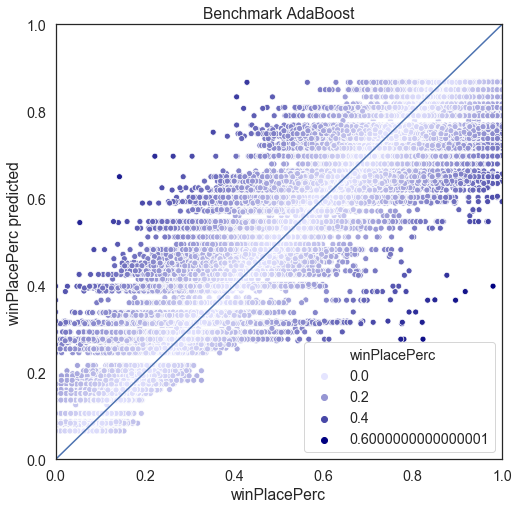

In [19]:
X = data_raw.drop('winPlacePerc', axis=1)
y = data_raw['winPlacePerc']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=config.RANDOM_STATE
)
predictions = regressor_benchmark.predict(X_test)

g = sns.scatterplot(x=y_test, y=predictions, hue=abs(predictions - y_test), palette=cmap)
g.set(title='Benchmark AdaBoost', xlabel='winPlacePerc', ylabel='winPlacePerc predicted')
sns.lineplot(x=[0,1], y=[0,1])

plt.ylim(0, 1)
plt.xlim(0, 1);

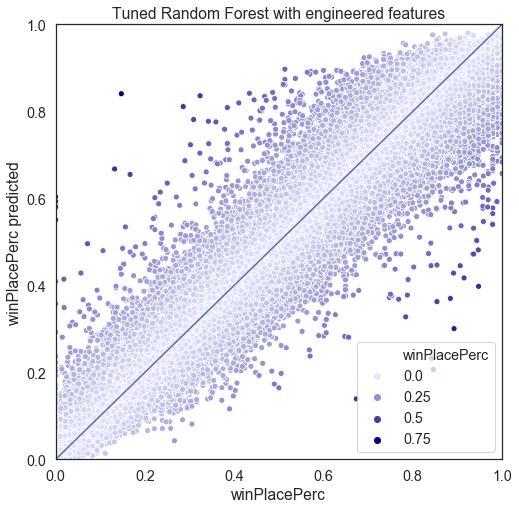

In [20]:
X = data.drop('winPlacePerc', axis=1)
y = data['winPlacePerc']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=config.RANDOM_STATE
)
predictions = regressor_rf_fe.predict(X_test)

g = sns.scatterplot(x=y_test, y=predictions, hue=abs(predictions - y_test), palette=cmap)
g.set(title='Tuned Random Forest with engineered features', xlabel='winPlacePerc', ylabel='winPlacePerc predicted')
sns.lineplot(x=[0,1], y=[0,1])

plt.ylim(0, 1)
plt.xlim(0, 1);